In [5]:
!nvidia-smi
!apt-get update -qq
!apt-get install -y nvidia-cuda-toolkit  > /dev/null
!nvcc --version | head -n 1

Sat Jun  7 09:16:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [8]:
%%bash
cat > hello.cu <<'EOF'
#include <stdio.h>
__global__ void hello(){ printf("Hello from GPU!\\n"); }
int main(){
    hello<<<1,1>>>();
    cudaDeviceSynchronize();
    return 0;
}
EOF

nvcc hello.cu -o hello
./hello

In [9]:
!git clone --depth 1 https://github.com/NVIDIA-developer-blog/code-samples.git

Cloning into 'code-samples'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 372 (delta 120), reused 309 (delta 99), pack-reused 0 (from 0)
Receiving objects: 100% (372/372), 1.67 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [10]:
%cd code-samples/posts/easy-intro-cuda/saxpy

[Errno 2] No such file or directory: 'code-samples/posts/easy-intro-cuda/saxpy'
/content


In [11]:
!git clone --depth 1 https://github.com/NVIDIA-developer-blog/code-samples.git
%cd code-samples/posts/easy-intro-cuda/saxpy

fatal: destination path 'code-samples' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'code-samples/posts/easy-intro-cuda/saxpy'
/content


In [12]:
!rm -rf code-samples

In [13]:
!git clone --depth 1 https://github.com/NVIDIA-developer-blog/code-samples.git

Cloning into 'code-samples'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 372 (delta 120), reused 309 (delta 99), pack-reused 0 (from 0)
Receiving objects: 100% (372/372), 1.67 MiB | 14.12 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [14]:
%cd /content/code-samples/posts/easy-intro-cuda/saxpy

[Errno 2] No such file or directory: '/content/code-samples/posts/easy-intro-cuda/saxpy'
/content


In [15]:
!rm -rf code-samples

In [16]:
!git clone --depth 1 https://github.com/NVIDIA-developer-blog/code-samples.git

Cloning into 'code-samples'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 372 (delta 120), reused 309 (delta 99), pack-reused 0 (from 0)
Receiving objects: 100% (372/372), 1.67 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [17]:
!find code-samples -type f -name 'saxpy.cu'

code-samples/posts/grcuda/kernel/saxpy.cu


In [18]:
%cd code-samples/posts/grcuda/kernel

/content/code-samples/posts/grcuda/kernel


In [19]:
!ls

saxpy.cu  saxpy_nvrtc.py  saxpy.py


In [20]:
!nvcc -O3 saxpy.cu -o saxpy

saxpy.cu:28:8: warning: invalid suffix on literal; C++11 requires a space between literal and string macro []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wliteral-suffix-Wliteral-suffix]8;;]
   28 | extern "C"__global__
      |        ^
saxpy.cu:28:8: warning: invalid suffix on literal; C++11 requires a space between literal and string macro []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wliteral-suffix-Wliteral-suffix]8;;]
   28 | extern "C"__global__
      |        ^
/usr/bin/ld: /usr/lib/gcc/x86_64-linux-gnu/11/../../../x86_64-linux-gnu/Scrt1.o: in function `_start':
(.text+0x1b): undefined reference to `main'
collect2: error: ld returned 1 exit status


In [21]:
!./saxpy

/bin/bash: line 1: ./saxpy: No such file or directory


In [22]:
!ls

saxpy.cu  saxpy_nvrtc.py  saxpy.py


In [23]:
%%bash
cat > saxpy_bench.cu <<'EOF'
#include <cstdio>
#include <cuda_runtime.h>

__global__ void saxpy(int n, float a, float *x, float *y){
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if(i < n) y[i] = a * x[i] + y[i];
}

int main(){
    const int first_pow = 15, last_pow = 25;        // 2^15 … 2^25
    for(int p = first_pow; p <= last_pow; ++p){
        int N = 1 << p;
        size_t bytes = N * sizeof(float);

        float *h_x = (float*)malloc(bytes);
        float *h_y = (float*)malloc(bytes);
        for(int i = 0; i < N; ++i){ h_x[i] = 1.0f; h_y[i] = 2.0f; }

        float *d_x, *d_y;
        cudaMalloc(&d_x, bytes);  cudaMalloc(&d_y, bytes);
        cudaMemcpy(d_x, h_x, bytes, cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, h_y, bytes, cudaMemcpyHostToDevice);

        dim3 block(256);
        dim3 grid((N + block.x - 1) / block.x);

        cudaEvent_t t0, t1;
        cudaEventCreate(&t0);  cudaEventCreate(&t1);

        // total time (H2D + kernel + D2H)
        cudaEventRecord(t0);
        saxpy<<<grid, block>>>(N, 2.0f, d_x, d_y);
        cudaMemcpy(h_y, d_y, bytes, cudaMemcpyDeviceToHost);
        cudaEventRecord(t1);  cudaEventSynchronize(t1);
        float total_ms;  cudaEventElapsedTime(&total_ms, t0, t1);

        // kernel‑only time
        cudaEventRecord(t0);
        saxpy<<<grid, block>>>(N, 2.0f, d_x, d_y);
        cudaEventRecord(t1);  cudaEventSynchronize(t1);
        float kernel_ms; cudaEventElapsedTime(&kernel_ms, t0, t1);

        printf("%d,%f,%f\n", N, total_ms, kernel_ms);   // CSV line

        cudaFree(d_x); cudaFree(d_y); free(h_x); free(h_y);
        cudaEventDestroy(t0); cudaEventDestroy(t1);
    }
    return 0;
}
EOF

In [24]:
!nvcc -O3 saxpy_bench.cu -o saxpy_bench

In [25]:
!./saxpy_bench > /content/saxpy_times.csv

In [26]:
!head /content/saxpy_times.csv

32768,12.297184,0.002944
65536,0.109152,0.002496
131072,0.188128,0.002528
262144,0.312992,0.002752
524288,0.496128,0.002528
1048576,0.858560,0.002624
2097152,1.868672,0.003232
4194304,3.472768,0.002784
8388608,6.910304,0.002624
16777216,14.482624,0.003328


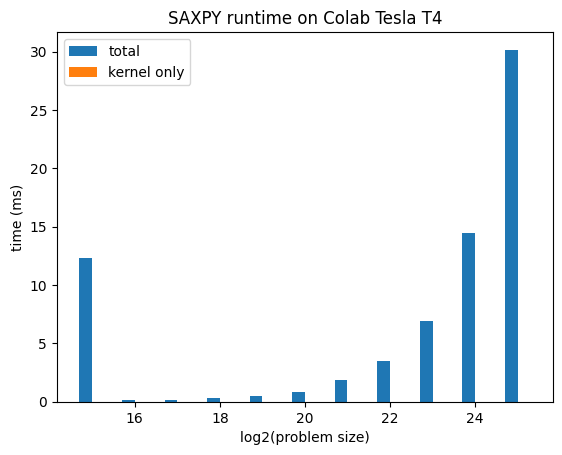

In [27]:
import numpy as np, matplotlib.pyplot as plt
N, total, kernel = np.loadtxt("/content/saxpy_times.csv", delimiter=",", unpack=True)
plt.bar(np.log2(N)-0.15, total, width=0.3, label="total")
plt.bar(np.log2(N)+0.15, kernel, width=0.3, label="kernel only")
plt.xlabel("log2(problem size)"); plt.ylabel("time (ms)")
plt.title("SAXPY runtime on Colab Tesla T4"); plt.legend(); plt.show()

In [28]:
!./saxpy_bench > /content/saxpy_times.csv

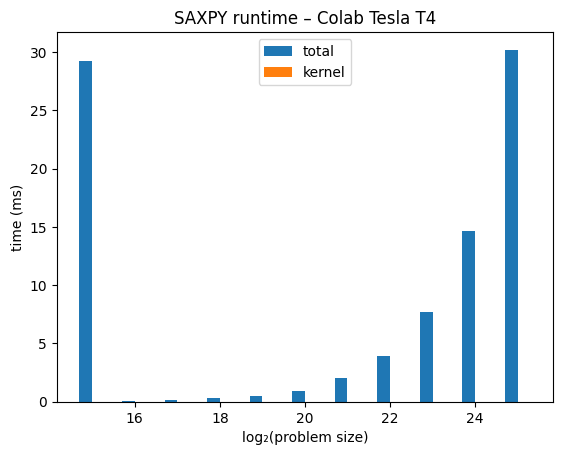

In [29]:
import numpy as np, matplotlib.pyplot as plt
N, tot, ker = np.loadtxt("/content/saxpy_times.csv", delimiter=",", unpack=True)
plt.bar(np.log2(N)-0.15, tot, 0.3, label="total")
plt.bar(np.log2(N)+0.15, ker, 0.3, label="kernel")
plt.xlabel("log₂(problem size)"); plt.ylabel("time (ms)")
plt.title("SAXPY runtime – Colab Tesla T4"); plt.legend(); plt.show()

In [31]:
%%writefile /content/saxpy_bench.cu
<‑‑‑‑ paste the full saxpy_bench.cu code here exactly as shown earlier ‑‑‑‑>

Writing /content/saxpy_bench.cu


In [32]:
!nvcc -O3 /content/saxpy_bench.cu -o /content/saxpy_bench
!./saxpy_bench > /content/saxpy_times.csv

/content/saxpy_bench.cu:1:2: error: extended character ‑ is not valid in an identifier
    1 | <‑‑‑‑ paste the full saxpy_bench.cu code here exactly as shown earlier ‑‑‑‑>
      |  ^
/content/saxpy_bench.cu:1:2: error: extended character ‑ is not valid in an identifier
/content/saxpy_bench.cu:1:2: error: extended character ‑ is not valid in an identifier
/content/saxpy_bench.cu:1:2: error: extended character ‑ is not valid in an identifier
/content/saxpy_bench.cu:1:72: error: extended character ‑ is not valid in an identifier
    1 | <‑‑‑‑ paste the full saxpy_bench.cu code here exactly as shown earlier ‑‑‑‑>
      |                                                                        ^
/content/saxpy_bench.cu:1:72: error: extended character ‑ is not valid in an identifier
/content/saxpy_bench.cu:1:72: error: extended character ‑ is not valid in an identifier
/content/saxpy_bench.cu:1:72: error: extended character ‑ is not valid in an identifier


In [33]:
!rm -f /content/saxpy_bench.cu

In [34]:
%%bash
cat > /content/saxpy_bench.cu <<'EOF'
/**
 * saxpy_bench.cu  -- CUDA SAXPY micro‑benchmark
 * Measures total vs kernel‑only runtime for N = 2^15 … 2^25.
 * Compile: nvcc -O3 saxpy_bench.cu -o saxpy_bench
 * Run:     ./saxpy_bench > saxpy_times.csv
 */
#include <cstdio>
#include <cuda_runtime.h>

__global__ void saxpy(int n, float a, float* x, float* y)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = a * x[i] + y[i];
}

int main()
{
    const int first_pow = 15, last_pow = 25;            // 2^15 … 2^25
    for (int p = first_pow; p <= last_pow; ++p)
    {
        int    N     = 1 << p;
        size_t bytes = N * sizeof(float);

        // host buffers
        float *h_x = (float*)malloc(bytes);
        float *h_y = (float*)malloc(bytes);
        for (int i = 0; i < N; ++i) { h_x[i] = 1.0f; h_y[i] = 2.0f; }

        // device buffers
        float *d_x, *d_y;
        cudaMalloc(&d_x, bytes);
        cudaMalloc(&d_y, bytes);

        cudaMemcpy(d_x, h_x, bytes, cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, h_y, bytes, cudaMemcpyHostToDevice);

        dim3 block(256);
        dim3 grid((N + block.x - 1) / block.x);

        cudaEvent_t t0, t1;
        cudaEventCreate(&t0);  cudaEventCreate(&t1);

        // --- TOTAL time (H2D + kernel + D2H) -------------------------
        cudaEventRecord(t0);
        saxpy<<<grid, block>>>(N, 2.0f, d_x, d_y);
        cudaMemcpy(h_y, d_y, bytes, cudaMemcpyDeviceToHost);
        cudaEventRecord(t1);  cudaEventSynchronize(t1);
        float total_ms = 0.0f;
        cudaEventElapsedTime(&total_ms, t0, t1);

        // --- KERNEL‑ONLY time ---------------------------------------
        cudaEventRecord(t0);
        saxpy<<<grid, block>>>(N, 2.0f, d_x, d_y);
        cudaEventRecord(t1);  cudaEventSynchronize(t1);
        float kernel_ms = 0.0f;
        cudaEventElapsedTime(&kernel_ms, t0, t1);

        printf("%d,%.6f,%.6f\n", N, total_ms, kernel_ms);   // CSV line

        cudaFree(d_x); cudaFree(d_y); free(h_x); free(h_y);
        cudaEventDestroy(t0); cudaEventDestroy(t1);
    }
    return 0;
}
EOF

In [35]:
!nvcc -O3 /content/saxpy_bench.cu -o /content/saxpy_bench
!./saxpy_bench > /content/saxpy_times.csv


In [36]:
!head /content/saxpy_times.csv

32768,12.554560,0.003008
65536,0.199712,0.005664
131072,0.195680,0.002528
262144,0.328352,0.002528
524288,0.520544,0.002528
1048576,0.929312,0.002528
2097152,1.665088,0.002496
4194304,3.662624,0.003584
8388608,7.564352,0.003488
16777216,15.450688,0.004704


In [37]:
!nvcc -O3 /content/saxpy_bench.cu -o /content/saxpy_bench
!./saxpy_bench > /content/saxpy_times.csv

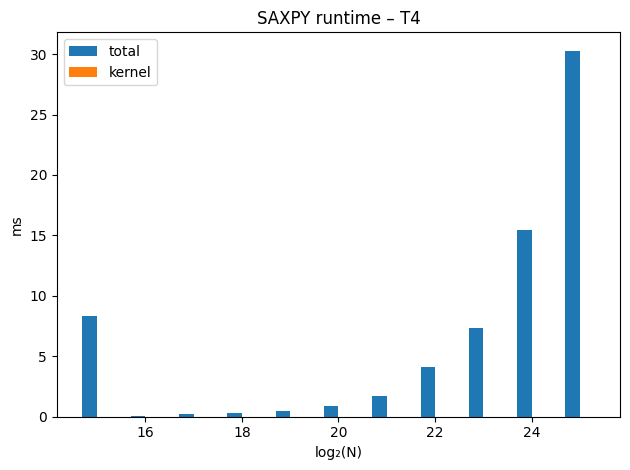

In [38]:
import numpy as np, matplotlib.pyplot as plt
N,tot,ker = np.loadtxt("/content/saxpy_times.csv", delimiter=",", unpack=True)
plt.bar(np.log2(N)-0.15, tot, 0.3, label="total")
plt.bar(np.log2(N)+0.15, ker, 0.3, label="kernel")
plt.xlabel("log₂(N)"); plt.ylabel("ms"); plt.title("SAXPY runtime – T4")
plt.legend(); plt.tight_layout()
plt.savefig("/content/plot.png", dpi=150)
plt.show()

In [39]:
import os, json, requests, IPython
ipynb_path = IPython.notebook.notebook_name  # works inside Colab

AttributeError: module 'IPython' has no attribute 'notebook'

In [40]:
import os, json, requests, IPython
ipynb_path = IPython.notebook.notebook_name

AttributeError: module 'IPython' has no attribute 'notebook'

In [41]:
from google.colab import files
files.download('saxpy_colab.ipynb'

SyntaxError: incomplete input (<ipython-input-41-dd4da032c58a>, line 2)

In [42]:
from google.colab import files
files.download('Saxpy.ipynb')

FileNotFoundError: Cannot find file: Saxpy.ipynb

In [43]:
from google.colab import files
files.download('Saxpy.ipynb')

FileNotFoundError: Cannot find file: Saxpy.ipynb